<a href="https://colab.research.google.com/github/KaidaUsagi/CNNsLarge/blob/main/CNNsLarge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Train with a large dataset: Cats and dogs**

In this codelab, you'll look at a real and very large dataset, and see the impact that it has on avoiding overfitting.

First, set up your development environment with the requisite libraries that you'll need.

In [ ]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

### **Get the data**

In [ ]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset
# Note: This is a very large dataset and will take time to download
!wget --no-check-certificate "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" -O "/tmp/cats-and-dogs.zip"
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))
# Expected Output:
# 12501
# 12501

--2023-12-13 20:44:35--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.212.72.155, 2600:1407:3c00:1293::317f, 2600:1407:3c00:1282::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.212.72.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  75.9MB/s    in 10s     

2023-12-13 20:44:45 (78.5 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]

12501
12501


### **Prepare the data**
Now that you downloaded the data, unzip it into training and testing directories. The following code achieves that:

In [ ]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)
# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


You can check to see if your data is properly unpacked using the following code:

In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))
# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


### **Define the model**

Next, define the model as a series of convolutional layers with max pooling.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

### **Train the model**

Now that the model is defined, you can train the model using an ImageDataGenerator.

In [ ]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


To train the model, you now call `model.fit_generator`, passing it to the generators that you created.

In [ ]:
# Note that this may take some time.
history = model.fit(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/15
 81/225 [=========>....................] - ETA: 5:24 - loss: 0.7087 - accuracy: 0.5556

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 [==============================] - 533s 2s/step - loss: 0.6380 - accuracy: 0.6341 - val_loss: 0.5867 - val_accuracy: 0.6724
Epoch 2/15
225/225 [==============================] - 520s 2s/step - loss: 0.5338 - accuracy: 0.7286 - val_loss: 0.5116 - val_accuracy: 0.7380
Epoch 3/15
225/225 [==============================] - 499s 2s/step - loss: 0.4745 - accuracy: 0.7709 - val_loss: 0.4103 - val_accuracy: 0.8068
Epoch 4/15
225/225 [==============================] - 529s 2s/step - loss: 0.4176 - accuracy: 0.8058 - val_loss: 0.3856 - val_accuracy: 0.8128
Epoch 5/15
225/225 [==============================] - 534s 2s/step - loss: 0.3706 - accuracy: 0.8325 - val_loss: 0.2908 - val_accuracy: 0.8776
Epoch 6/15
225/225 [==============================] - 522s 2s/step - loss: 0.3163 - accuracy: 0.8641 - val_loss: 0.2699 - val_accuracy: 0.8848
Epoch 7/15
225/225 [==============================] - 523s 2s/step - loss: 0.2502 - accuracy: 0.8960 - val_loss: 0.1517 - val_accuracy: 0.9548
Epoch 8/15

### **Explore the results**

You can explore and plot the training and validation accuracy with the following code. Use it to see when you reach maximum training efficiency and see whether you're overfitting.

<Figure size 640x480 with 0 Axes>

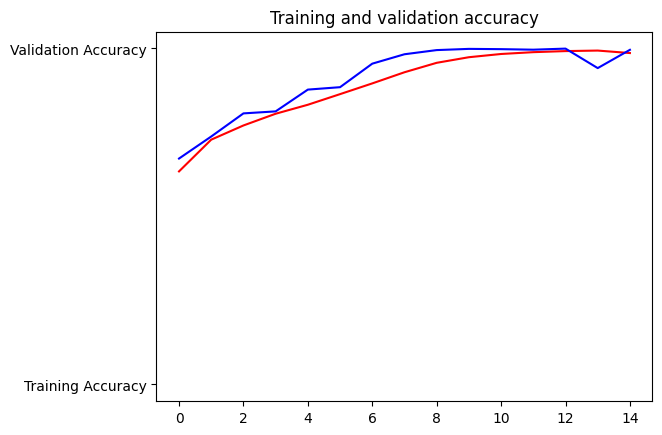

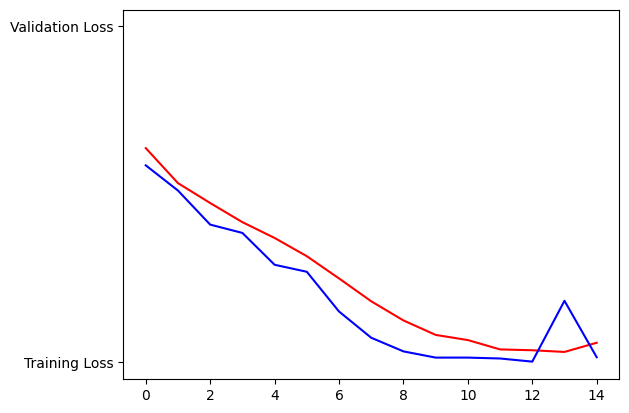

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

### **Test your model**
If you want to take the model for a spin, you can use the following code. Upload images to see how it classifies them!

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")